In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/workspace')
import src

In [2]:
def get_cfg(pos):
    with hydra.initialize(config_path="../conf", version_base='1.1'):
        cfg = hydra.compose(
            config_name='config',
            overrides=[
                "model=KAN1h",
                "model.model.width.0=2",
                "model.model.width.1=1",
                "model.model.grid=17",
                "model.train_params.steps=3000",
                "dataset@train=masking_sim",
                "dataset@test=masking_sim",
                "trace_transforms=void",
                "label_transforms=bit_sim",
                f"label_transforms.transforms.0.pos={pos}",
                f"save_path=/workspace/results/simulation/KAN_All/0/grid17",
                ]
            )
    return cfg

In [3]:
def train(cfg):
    device = hydra.utils.instantiate(cfg.device)
    cpu = torch.device('cpu')

    # Dataset
    profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
    test_dataset = hydra.utils.instantiate(cfg.test.dataset)

    train_dataloader = torch.utils.data.DataLoader(
        profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=cfg.test.batch_size, shuffle=False
    )
    KANds = src.utils.to_KAN_dataset(
        train_dataloader, test_dataloader,
        device=device)

    # Train
    model = hydra.utils.instantiate(cfg.model.model)
    _ = model(KANds['train_input'])
    model.fix_symbolic(0,0,0, 'x')
    model.fix_symbolic(0,1,0, 'x')
    model = model.to(device)
    _ = model.train(
        KANds,
        **hydra.utils.instantiate(cfg.model.train_params)
        )
    Path(cfg.save_path).mkdir(exist_ok=True, parents=True)
    model.to(cpu).save_ckpt(cfg.model_name+'.ckpt', cfg.save_path)

    # Test
    preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device)
    preds_class = np.argmax(preds, axis=1)
    accuracy = np.mean(labels == preds_class)
    print('Accuracy: ', accuracy)

    return model, KANds, test_dataset, test_dataloader, device

In [4]:
cfg = get_cfg(0)
model, KANds, test_dataset, test_dataloader, device = train(cfg)

r2 is 0.995833694934845
r2 is 0.9952849745750427


train loss: 8.31e-01 | test loss: 8.24e-01 | reg: 5.45e-01 : 100%|█| 3000/3000 [02:07<00:00, 23.57it


save this model to /workspace/results/simulation/KAN_All/0/grid17/KAN-1Hidden.ckpt
Accuracy:  0.530975341796875


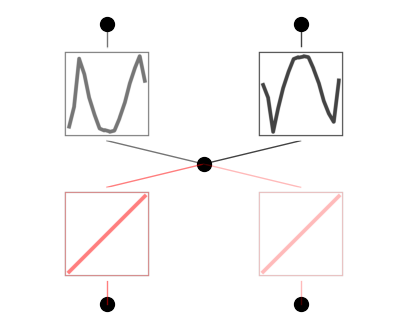

In [6]:
_ = model(KANds['train_input'])
model.plot(folder=cfg.save_path)
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}.png'),
    dpi=300, bbox_inches=0)
src.utils.plot_KAN(cfg, model, 'plot')